# Lecture 1

Settings that make the plots look pretty on my Mac:

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


You will need 

* [corner](https://github.com/dfm/corner.py).  Makes "corner" plots of distributions from samples.
* [pystan](https://pystan.readthedocs.io/en/latest/).  `pip install pystan` has always worked well for me.  (If you need a good Python distribution, I recommend [anaconda](https://www.continuum.io), which comes with a complete `numpy`, `scipy`, `iPython`, etc stack.)
* [seaborn](https://seaborn.pydata.org).  `pip install seaborn`.  Seaborn is a plotting library.

In [2]:
import corner
import pystan
import seaborn as sns

These are my favourite plotting styles:

In [3]:
sns.set_context('talk') #sns.set_context('notebook') is probably better on your monitor
sns.set_palette('colorblind')
sns.set_style('ticks')

## Preliminaries (Notes)

* $p(d, \theta) = p\left( d \mid \theta \right) p\left( \theta \right) = p\left( \theta \mid d \right) p\left( d \right)$ is the fundamental quantity.  A "just so" story about how you obtained your data.
* Dimensions / forms.
* Sampling from versus writing down; normalisation.
* Almost always computing.
* One way to think about it is that $p$ describes *knowledge*.  For example:
  * If I knew $\theta$, what would I predict about $d$.
  * If I knew $d$, what would I predict about $\theta$.
* Marginalisation.

## Let's Get Started Fitting

We are going to focus today on [Hogg, et al. (2010)](https://arxiv.org/abs/1008.4686).  In this paper, the "just so" story will be evolving, but it always involves measuring data `x` and `y` which are (often) related by a linear relationship:
$$
y = m x + b
$$
For some reason (maybe we are cosmologists?) we are interested in the parameters $m$ and $b$.  Please read Hogg, et al. (2010)'s cautionary note about this!

* Warning about interpretation of b (we will explore this)!

I used [tabula](http://tabula.technology) to scrape the data table from Hogg's PDF.  When *you* post things on the arXiv, *you* should always include a link to machine readable tables to accompany the document.  You can post your data on [GitHub](https://github.com), or if you want more archive-quality repositories that are citable (e.g. generate a DOI), consider something like [Zenodo](https://zenodo.org).  Hogg & company, normally so good in this respect, dropped the ball for this paper.

In [4]:
table1 = genfromtxt('HoggTable1.tsv', names=True)

<Container object of 3 artists>

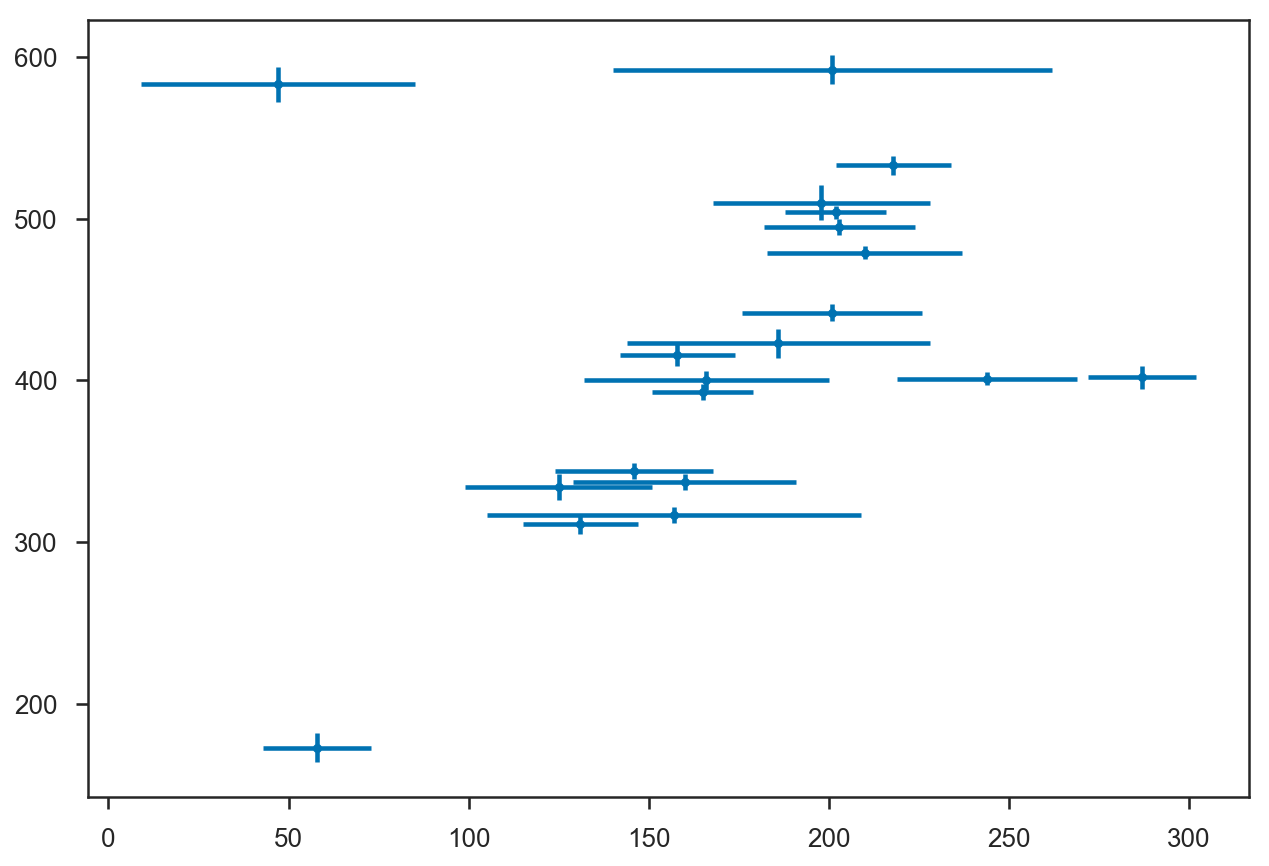

In [5]:
errorbar(table1['x'], table1['y'], xerr=table1['sigma_x'], yerr=table1['sigma_y'], fmt='.')

### Exercise 1

(I know that this can be computed analytically---and Hogg, et al. (2010) tell you how---but we're going to be computing anyway, so let's do it that way first.)

To do some fits, we will be using [Stan](http://mc-stan.org) (named, by the way for [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam)).  Stan is a specialised language for describing joint distributions of data and parameters.  Once the description is written down, Stan compiles the description to a C++ program that draws samples from the conditional distribution $p\left( \theta \mid d \right)$; a C++ compiler on your machine translates that into executable code, which we then drive from Python.  Whew.

For exercise 1, we assume that 
$$
y_\mathrm{true} = m x_\mathrm{true} + b
$$
and 
$$
y_\mathrm{obs} = y_\mathrm{true} + \sigma_y
$$

* Write stan program.

In [75]:
model = pystan.StanModel(file='linear_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_70a875d88505bb180d2df34c7eae85a1 NOW.


Exercise 1 asks us to fit all the data from the 5th to the 20th point, and ignore the uncertainty in $y$.

In [76]:
ex1N0 = 4

In [77]:
ex1_data = {'npts': table1['x'][ex1N0:].shape[0],
            'xs': table1['x'][ex1N0:],
            'ys': table1['y'][ex1N0:],
            'sigma_ys': table1['sigma_y'][ex1N0:]}

Inference for Stan model: anon_model_70a875d88505bb180d2df34c7eae85a1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m      2.33  1.7e-3   0.04   2.25    2.3   2.33   2.36   2.42    592    1.0
b      3.42    0.31   7.43 -11.53  -1.64   3.42   8.58  17.84    581    1.0
lp__ -202.3    0.03   0.98 -205.0 -202.7 -202.0 -201.6 -201.4   1110    1.0

Samples were drawn using NUTS at Mon Jul 10 17:03:42 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

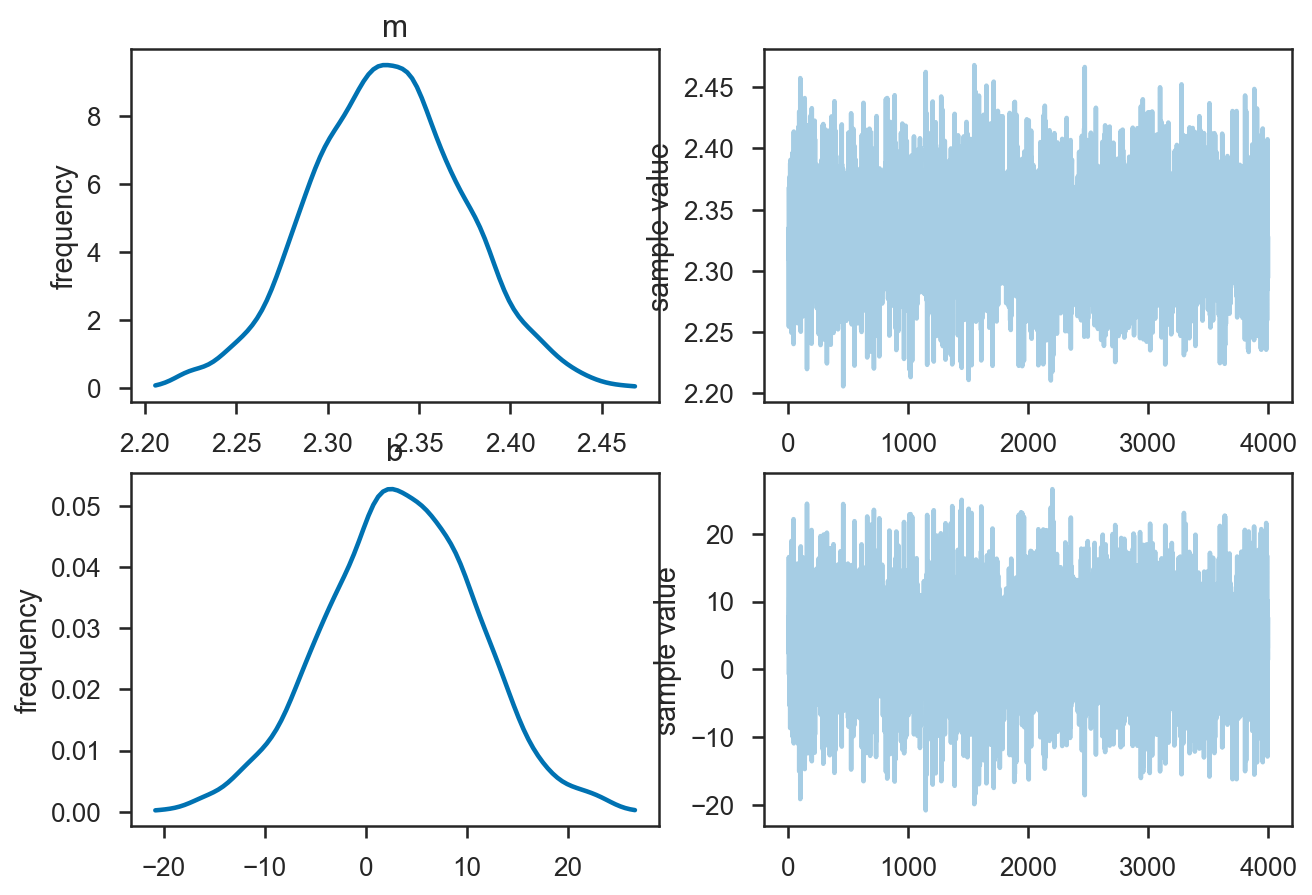

In [78]:
ex1_fit = model.sampling(data=ex1_data)
ex1_fit.plot()
ex1_fit

In [79]:
ex1_samples = ex1_fit.extract(permuted=True)

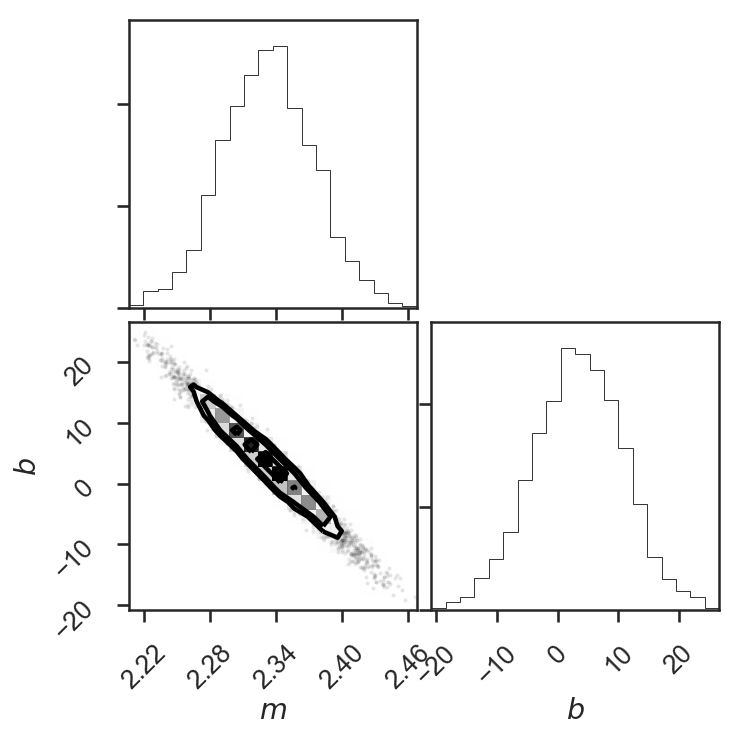

In [80]:
corner.corner(column_stack((ex1_samples['m'], ex1_samples['b'])), labels=[r'$m$', r'$b$']);

We *always* want to plot the output of our models in data space, to check whether the fit is good.  Let's define a function that does this:

In [81]:
def plot_errorbands(xs, ms, bs, *args, **kwargs):
    ys = []
    for m,b in zip(ms, bs):
        ys.append(m*xs + b)
    ys = array(ys)
    
    line, = plot(xs, median(ys, axis=0), *args, **kwargs)
    fill_between(xs, percentile(ys, 84, axis=0), percentile(ys, 16, axis=0), alpha=0.25, color=line.get_color())
    fill_between(xs, percentile(ys, 97.5, axis=0), percentile(ys, 2.5, axis=0), alpha=0.25, color=line.get_color())

A somewhat subtle point: our model has *implications* for $y_\mathrm{true}$.  $y_\mathrm{true} = m x + b$.  Thus we have a posterior on $y_\mathrm{true}$:

In [82]:
def plot_ytrues_no_scatter(xs, ms, bs, *args, **kwargs):
    ytrues = []
    for m,b in zip(ms, bs):
        ytrues.append(m*xs + b)
    ytrues = array(ytrues)
    
    errorbar(xs, mean(ytrues, axis=0), yerr=std(ytrues, axis=0), fmt='.', *args, **kwargs)

You can see that our uncertainty is very small.  In fact, they are so small, that our model is clearly inconsistent with the measurements---the green dots + errorbars are the *model* predictions, and they are *wildly* inconsistent with the data in black.  Something must be done.

<Container object of 3 artists>

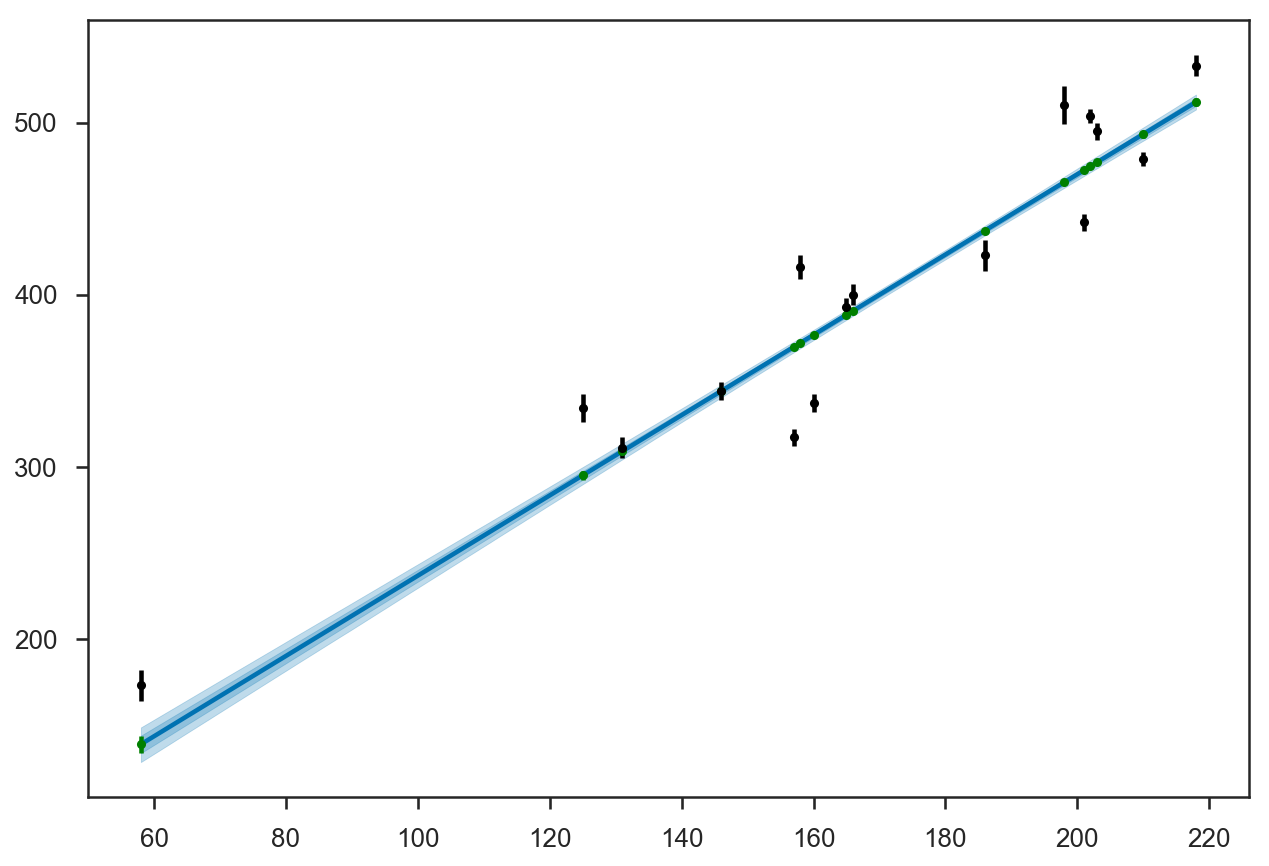

In [83]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), ex1_samples['m'], ex1_samples['b'])
plot_ytrues_no_scatter(table1['x'][ex1N0:], ex1_samples['m'], ex1_samples['b'], color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

Places to go from here:
* Exercise 2: Fit the crappy data.
* Improve the model (it's obviously bad)?
* Better priors?
* Deal with outliers.

Ilya suggested that we try to inflate the observed uncertainties by some constant factor until the fit is good (and I made a lot of fun at his expense because this model is saying you don't trust the observational errorbars---thanks for being a good sport, Ilya).

I have limited the scaling factor between 0.1 and 10.0.

In [84]:
model_ilya = pystan.StanModel(file='linear_model_ilya_errors.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee1c29cd590d90290155d79cdc90968b NOW.


Inference for Stan model: anon_model_ee1c29cd590d90290155d79cdc90968b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m                    2.34  7.1e-3   0.23   1.86   2.18   2.33   2.49   2.79   1074    1.0
b                    2.79    1.27  41.61  -78.3 -24.82   2.72  29.98  88.75   1077    1.0
ilyas_idiot_factor    5.3    0.03   0.99   3.78   4.59   5.15   5.84   7.66   1020    1.0
lp__               -66.14    0.05   1.51 -70.11 -66.79 -65.74 -65.04 -64.45    804    1.0

Samples were drawn using NUTS at Mon Jul 10 17:04:41 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

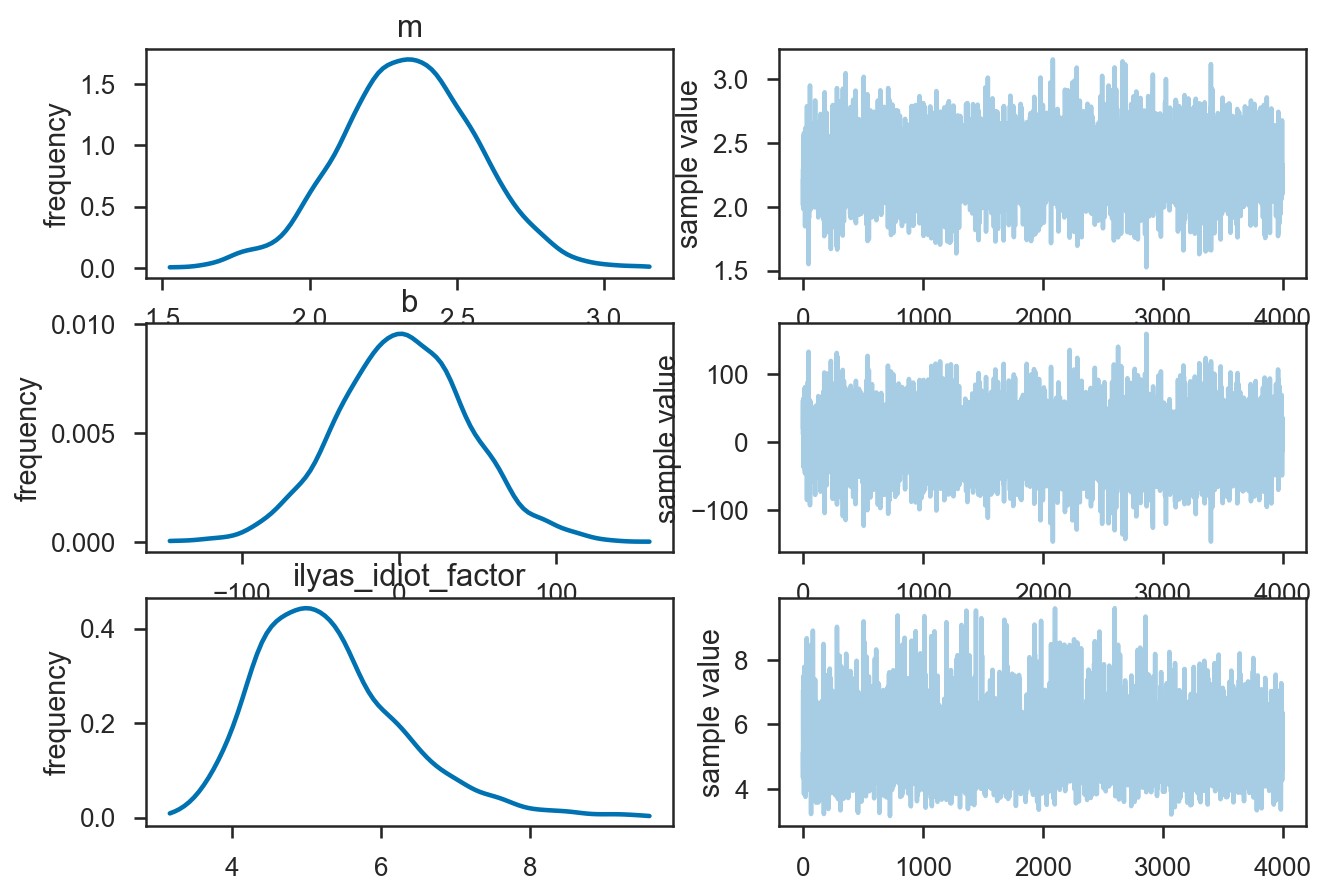

In [85]:
fit_ilya = model_ilya.sampling(data=ex1_data)
fit_ilya.plot()
fit_ilya

In [86]:
samples_ilya = fit_ilya.extract(permuted=True)

In particular, Ilya's suggestion would imply that the observers have under-stated their errorbars by a factor of ~5:

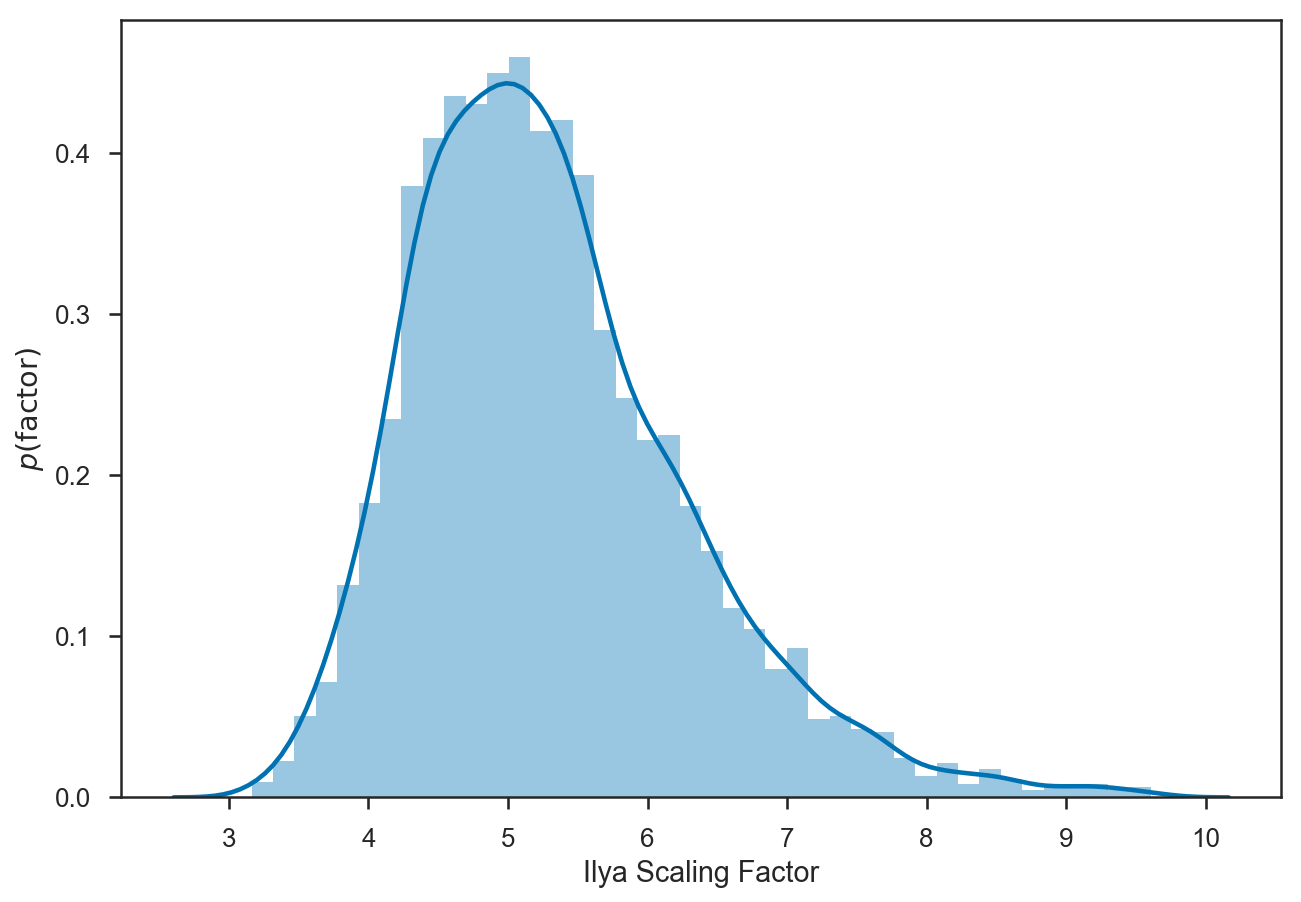

In [87]:
sns.distplot(samples_ilya['ilyas_idiot_factor'])
xlabel('Ilya Scaling Factor')
ylabel(r'$p\left( \mathrm{factor} \right)$')

<Container object of 3 artists>

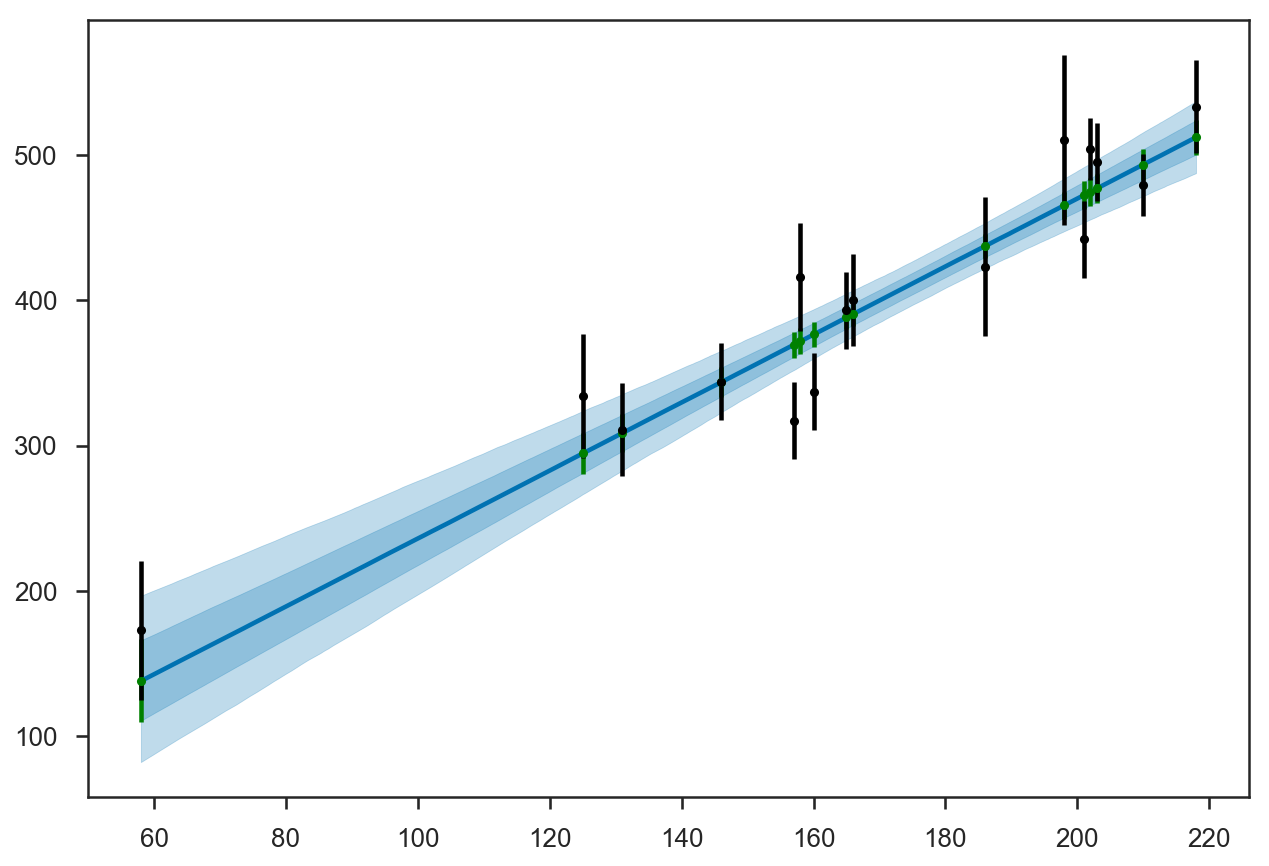

In [88]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_ilya['m'], samples_ilya['b'])
plot_ytrues_no_scatter(table1['x'][ex1N0:], samples_ilya['m'], samples_ilya['b'], color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=mean(samples_ilya['ilyas_idiot_factor'], axis=0)*table1['sigma_y'][ex1N0:], fmt='.', color='k')

An alternative model is that the observers got it right, but there is some "intrinsic" scatter in the relation.  We talked about how this could come about in lecture.  Our just-so story is now:
$$
y_\mathrm{true} \sim N\left( m x_\mathrm{true} + b, \sigma \right)
$$
with 
$$
y_\mathrm{obs} \sim N\left( y_\mathrm{true}, \sigma_y \right)
$$

In [90]:
model_scatter = pystan.StanModel(file='linear_model_scatter.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9ec8b6914580d488f7a11952c4631f56 NOW.


In [91]:
fit_scatter = model_scatter.sampling(data=ex1_data)

Inference for Stan model: anon_model_9ec8b6914580d488f7a11952c4631f56.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m            2.22  3.8e-3   0.22   1.79   2.07   2.22   2.36   2.65   3313    1.0
b           28.82    0.66  37.91 -44.49   4.64  29.12  53.01 103.37   3273    1.0
sigma       33.13    0.12   7.37  21.91  28.07  32.16  36.87   50.5   4000    1.0
y_true[0]  494.63    0.08   5.01 484.99 491.16 494.63 497.98 504.45   4000    1.0
y_true[1]  171.93    0.14   8.77 154.79  166.2 171.95 177.81 189.16   4000    1.0
y_true[2]  479.22    0.06   4.04 471.33 476.42 479.27 482.02 487.02   4000    1.0
y_true[3]  503.48    0.06   3.96  495.6 500.79 503.53 506.08 511.46   4000    1.0
y_true[4]  505.28    0.17  10.68 483.87 498.44 505.19 512.19 526.64   4000    1.0
y_true[5]   414.3    0.11   7.09 400.88 409.54 414.36 419.09 428.41   400

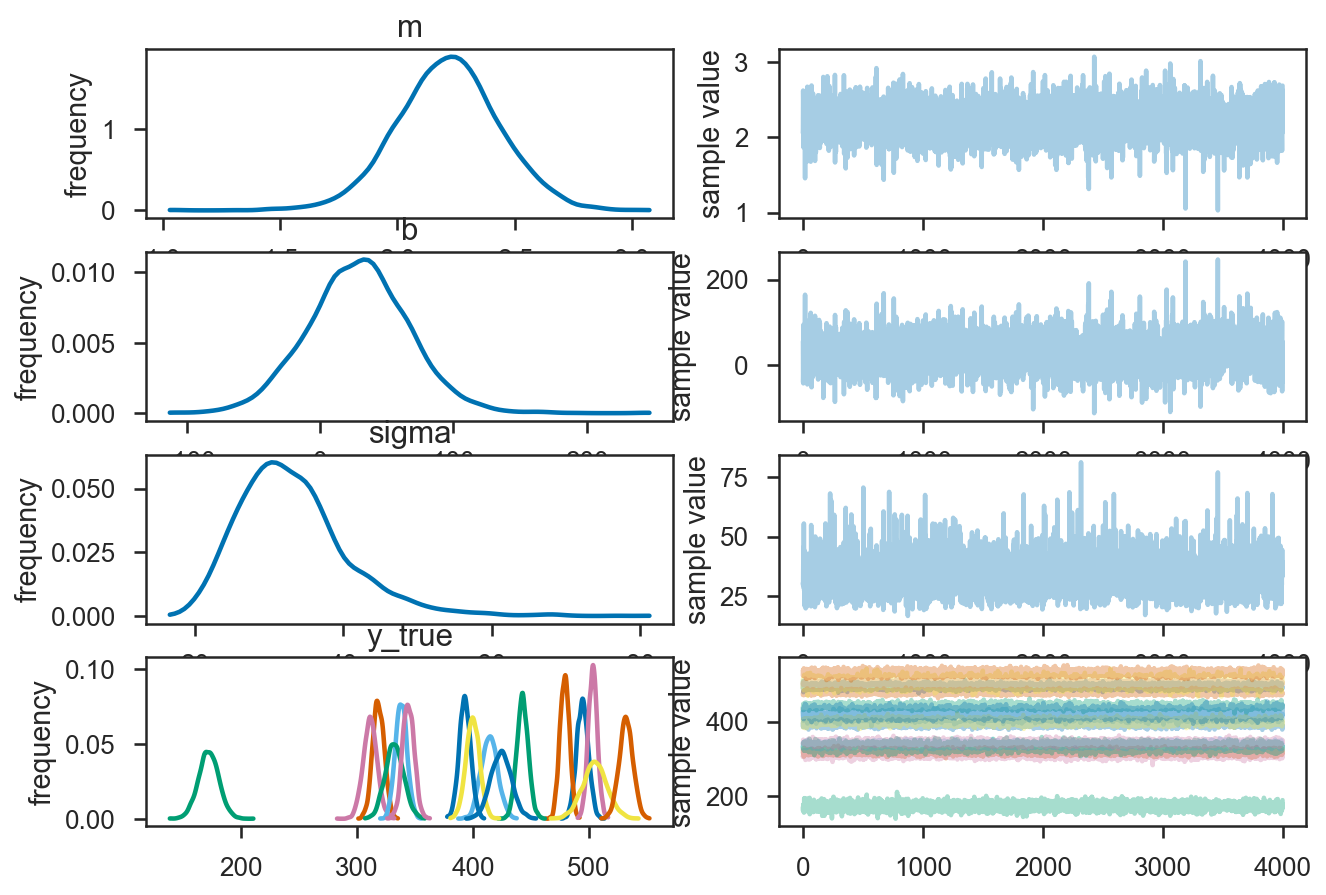

In [92]:
fit_scatter.plot()
fit_scatter

In [93]:
samples_scatter = fit_scatter.extract(permuted=True)

<Container object of 3 artists>

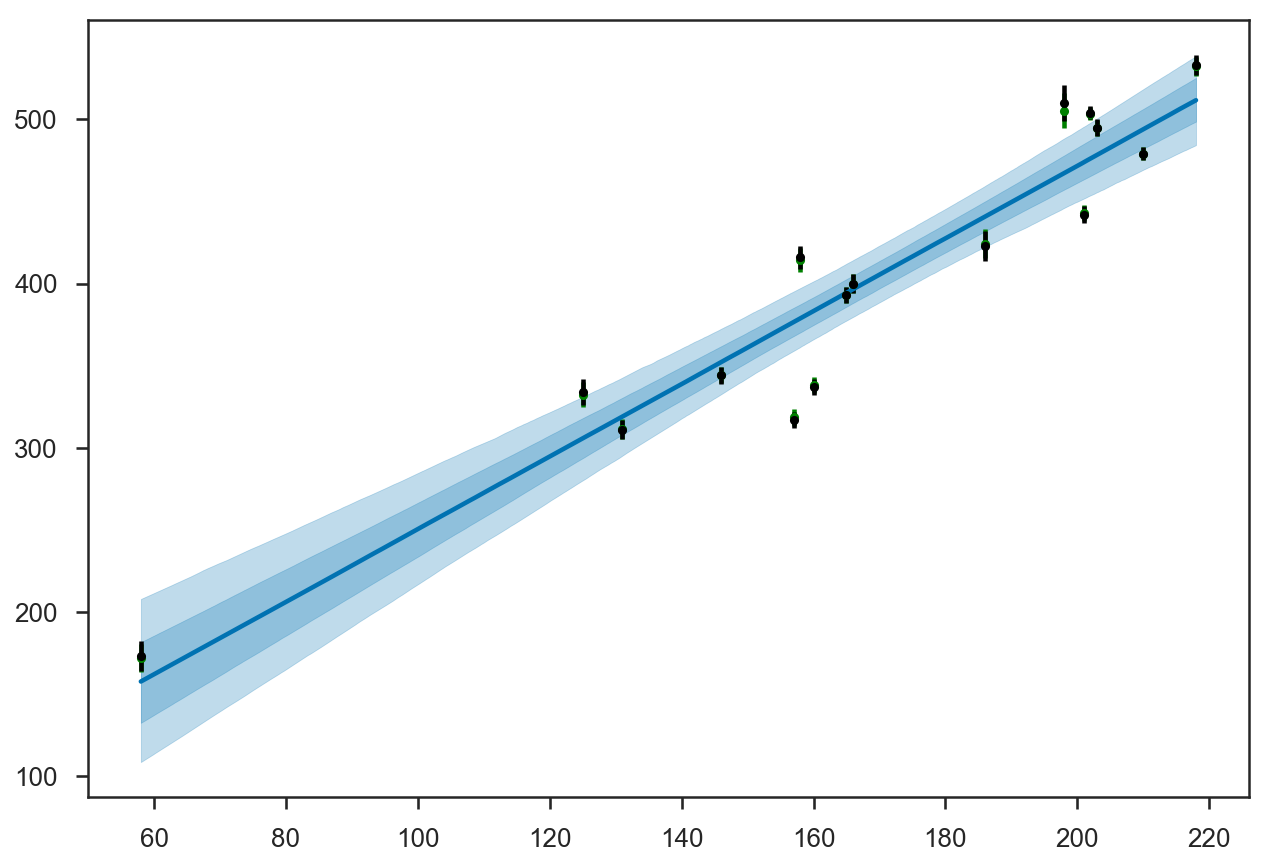

In [94]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_scatter['m'], samples_scatter['b'])
errorbar(table1['x'][ex1N0:], mean(samples_scatter['y_true'], axis=0), yerr=std(samples_scatter['y_true'], axis=0), fmt='.', color='g')
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

Note that in the last *three* models, I have sneakily put in posteriors over $y_\mathrm{true}$.  These models are *hierarchical* or *multilevel* or *partially pooled* (different communities have different names for this).  The posterior over $y_\mathrm{true}$ is a *weighted* combination of the observational uncertainty and the modelling uncertainty; by imposing a model, we allow observations of multiple data points to inform each other and reduce the uncertainty.  For example, here is the posterior on $y_\mathrm{true}$ for the worst-measured data point compared to the observational uncertainty.  Because the point lies above the fitted line, the posterior trends lower than the observation, but the error is significantly reduced.

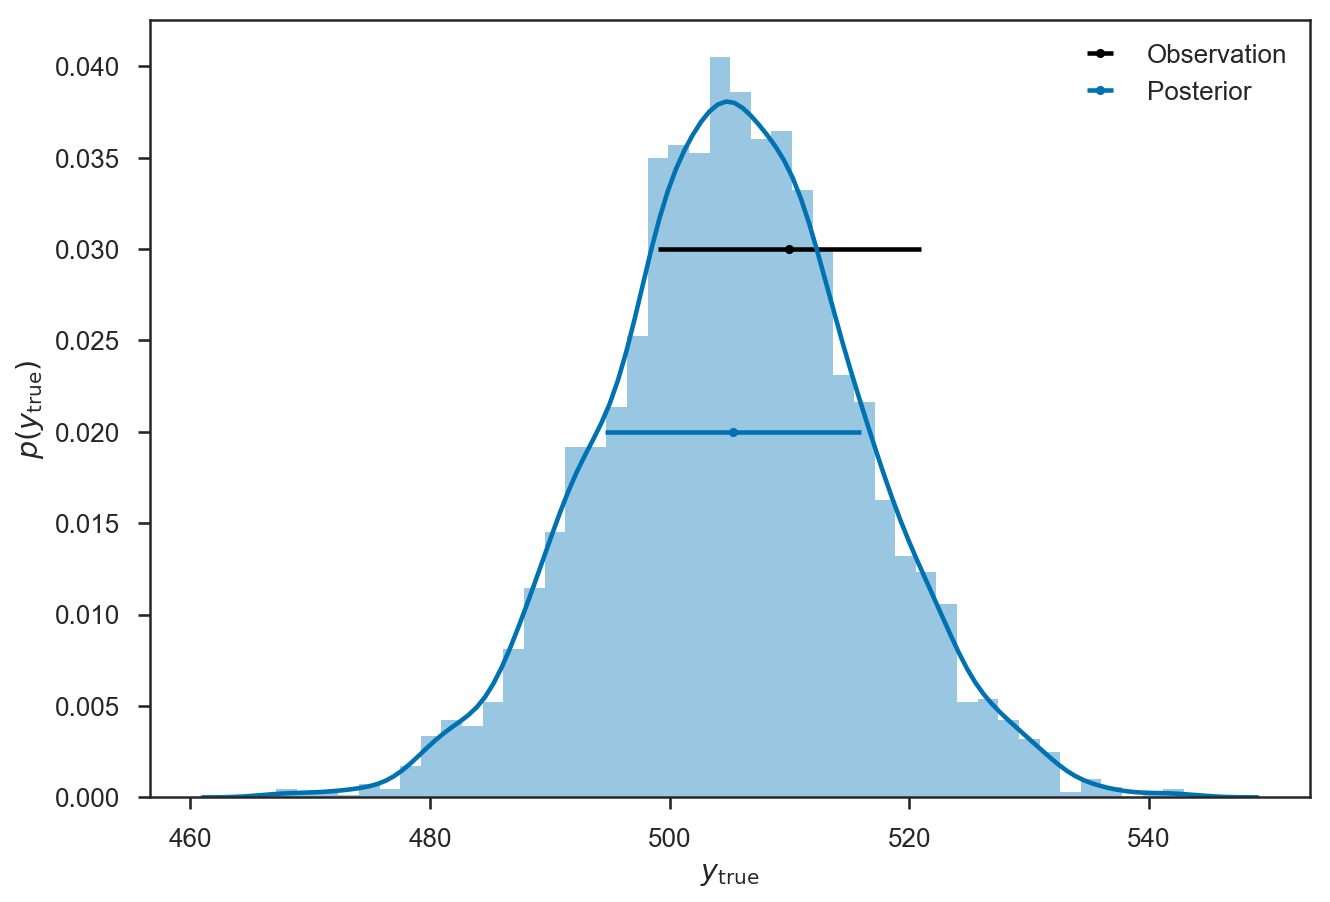

In [102]:
ind = argmax(table1['sigma_y'][ex1N0:])
sns.distplot(samples_scatter['y_true'][:,ind])
errorbar(table1['y'][ex1N0:][ind], 0.030, xerr=table1['sigma_y'][ex1N0:][ind], fmt='.', color='k', label='Observation')
errorbar(mean(samples_scatter['y_true'][:,ind]), 0.020, xerr=std(samples_scatter['y_true'][:,ind]), fmt='.', color=sns.color_palette()[0], label='Posterior')
legend(loc='best')
xlabel(r'$y_\mathrm{true}$')
ylabel(r'$p\left( y_\mathrm{true} \right)$')

Now let's try a fit including the "bad" data at face value:

In [103]:
data_bad = {'npts': table1['x'].shape[0],
            'xs': table1['x'],
            'ys': table1['y'],
            'sigma_ys': table1['sigma_y']}

In [104]:
fit_bad = model_scatter.sampling(data=data_bad)

Inference for Stan model: anon_model_9ec8b6914580d488f7a11952c4631f56.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m            0.64  9.4e-3   0.44  -0.22   0.36   0.64   0.92    1.5   2185    1.0
b          308.72     1.7  79.42 151.34 257.35 307.82  359.8 463.24   2183    1.0
sigma      105.55    0.35  19.67  74.59  91.57 103.02 116.44 150.58   3195    1.0
y_true[0]  590.73    0.14   8.98 573.18 584.61 590.57 596.85  609.0   4000    1.0
y_true[1]  401.02    0.06   3.98 393.51 398.22 400.98 403.76 408.74   4000    1.0
y_true[2]  579.99    0.18  11.24 557.86 572.48 579.97 587.53 601.92   4000    1.0
y_true[3]  402.48    0.11   7.02 388.75 397.73 402.46 407.25 416.14   4000    1.0
y_true[4]  494.84    0.08   4.99 484.83 491.41 494.91  498.2 504.44   4000    1.0
y_true[5]  174.44    0.14   9.06 156.37 168.64 174.35 180.31 192.89   400

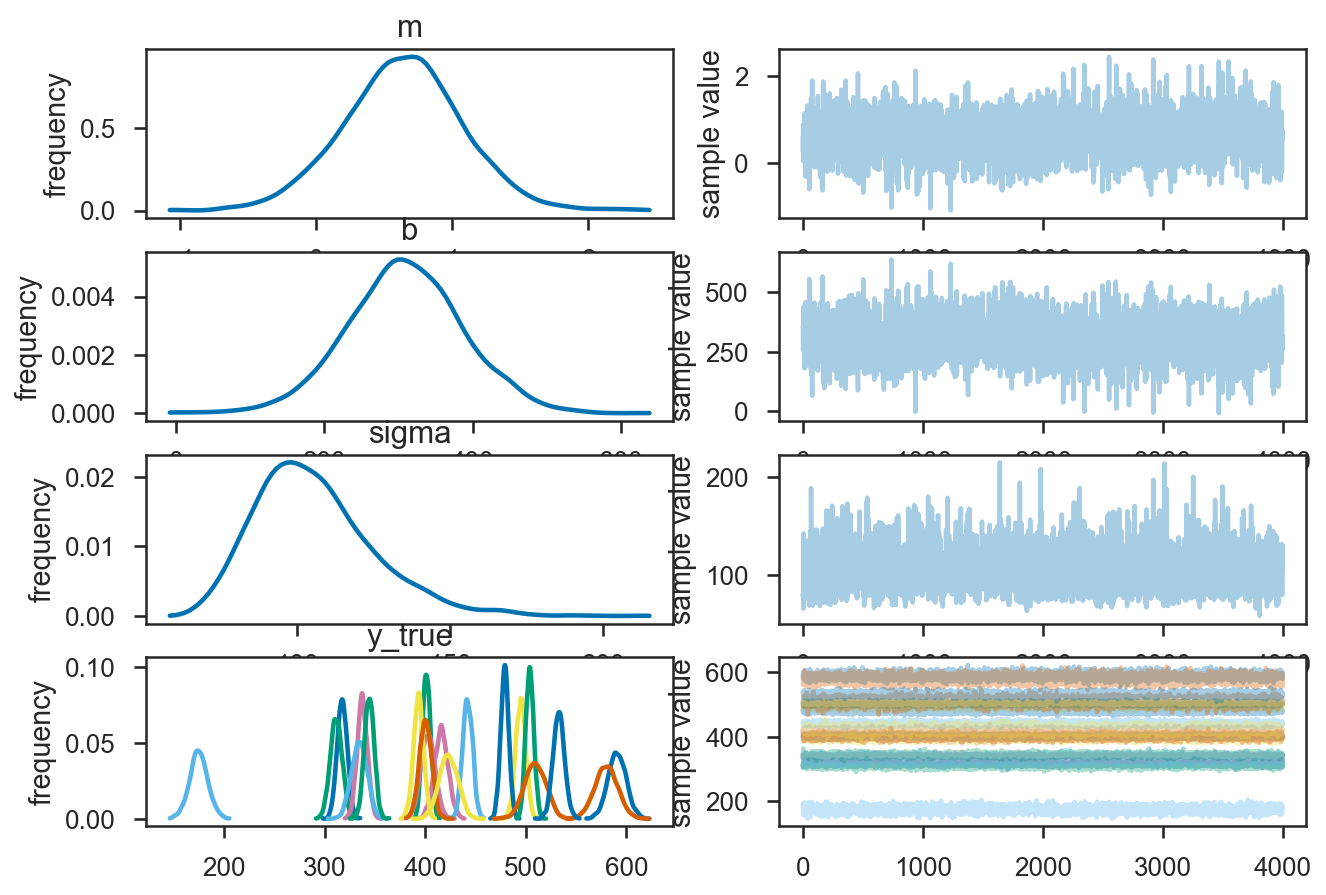

In [105]:
fit_bad.plot()
fit_bad

In [106]:
samples_bad = fit_bad.extract(permuted=True)

Ugh---that fit is eye-wateringly bad!  The outliers are pulling the slope way down!  How can we reject them?

<Container object of 3 artists>

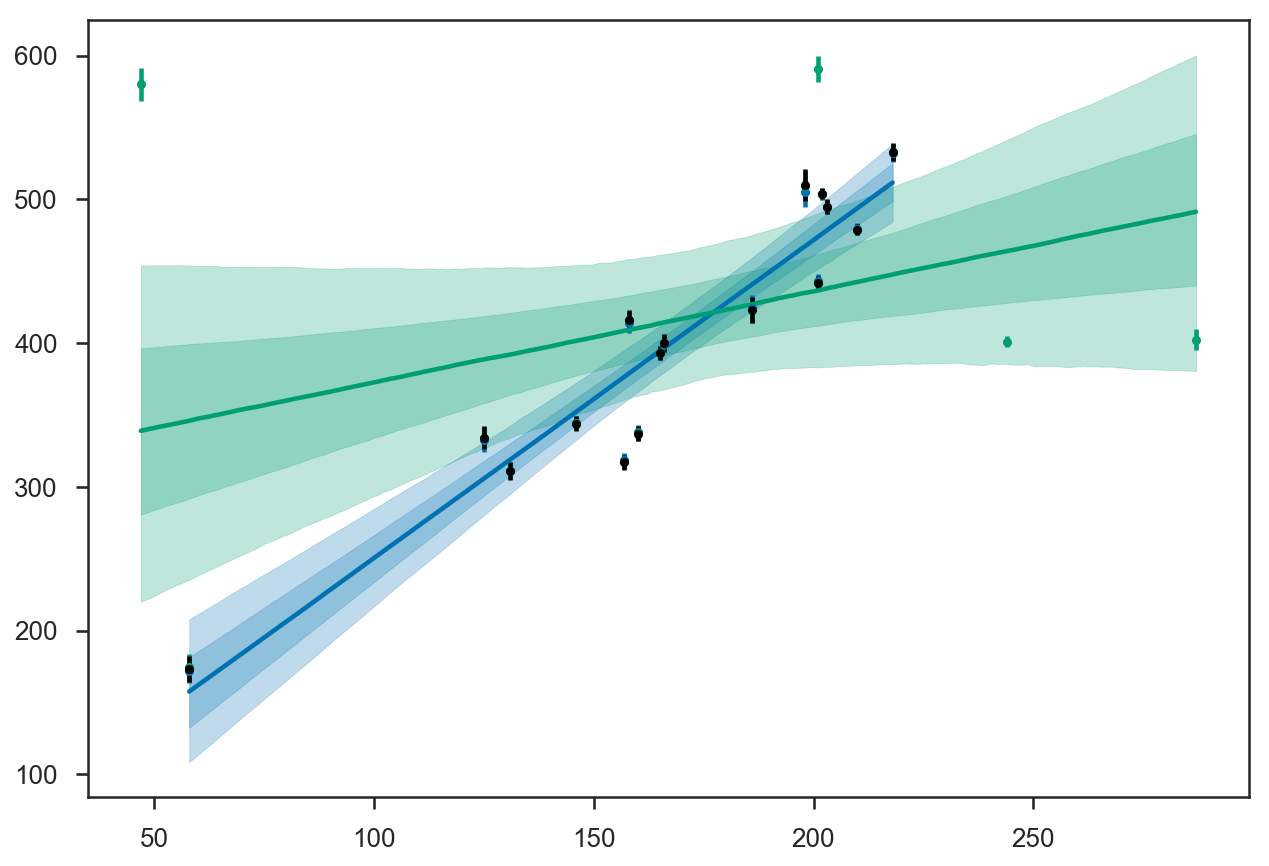

In [107]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_scatter['m'], samples_scatter['b'])
plot_errorbands(linspace(np.min(table1['x']), np.max(table1['x']), 1000), samples_bad['m'], samples_bad['b'])
errorbar(table1['x'][ex1N0:], mean(samples_scatter['y_true'], axis=0), yerr=std(samples_scatter['y_true'], axis=0), fmt='.', color=sns.color_palette()[0])
errorbar(table1['x'], mean(samples_bad['y_true'], axis=0), yerr=std(samples_bad['y_true'], axis=0), fmt='.', color=sns.color_palette()[1])
errorbar(table1['x'][ex1N0:], table1['y'][ex1N0:], yerr=table1['sigma_y'][ex1N0:], fmt='.', color='k')

Well, let's not reject them.  Let's suppose that our model is now a mixture of good data points and bad; the good ones come from a line while the bad ones just come from a Gaussian in $y$, independent of the $x$ values (see Hogg, et al. (2010) for discussion).  Thus:
$$
y_\mathrm{true} \sim A N\left( m x_\mathrm{true} + b, \sigma \right) + (1-A) N\left( \mu, \sigma'\right)
$$
with
$$
y \sim N\left( y_\mathrm{true}, \sigma_y\right).
$$
Here we will have to impose reasonable priors on all the parameters, because otherwise when $A = 1$ or $A = 0$ the parameters are "not identifiable" (that is, not constrained at all---just cut out of the likelihood) and we need to keep the sampler from running off to infinity.

See the Stan file for the specific priors I impose.

In [108]:
model_outilers = pystan.StanModel(file='linear_model_scatter_outlier.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c53f78aa88088a618bc83cf9fb2defb4 NOW.


In [109]:
fit_outliers = model_outilers.sampling(data=data_bad)

In [110]:
fit_outliers

Inference for Stan model: anon_model_c53f78aa88088a618bc83cf9fb2defb4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta           1.12  8.6e-3    0.1    0.8    1.1   1.14   1.16   1.21    132   1.02
b              48.64    4.31  58.29 -41.46  15.47  42.11  70.21 217.12    183   1.01
sigma          33.94    0.93  13.99  16.54  25.38  30.75  38.54  72.39    227   1.01
y_true[0]     590.52    0.14   9.16 571.92 584.52 590.61 596.53 608.16   4000    1.0
y_true[1]     401.01    0.06   4.05 392.92 398.28 401.07 403.71 408.86   4000    1.0
y_true[2]     581.99    0.18  11.39 560.17 574.12 581.94  590.0 603.93   4000    1.0
y_true[3]     402.29    0.11   6.66 389.02 397.74 402.42 406.74 415.56   4000    1.0
y_true[4]     494.61    0.08   4.82  485.2 491.38 494.64 497.81 504.17   4000    1.0
y_true[5]     172.32    0.14   8.89 155.24 166

In [111]:
samples_outliers = fit_outliers.extract(permuted=True)

And now the sampling looks much more reasonable:

<Container object of 3 artists>

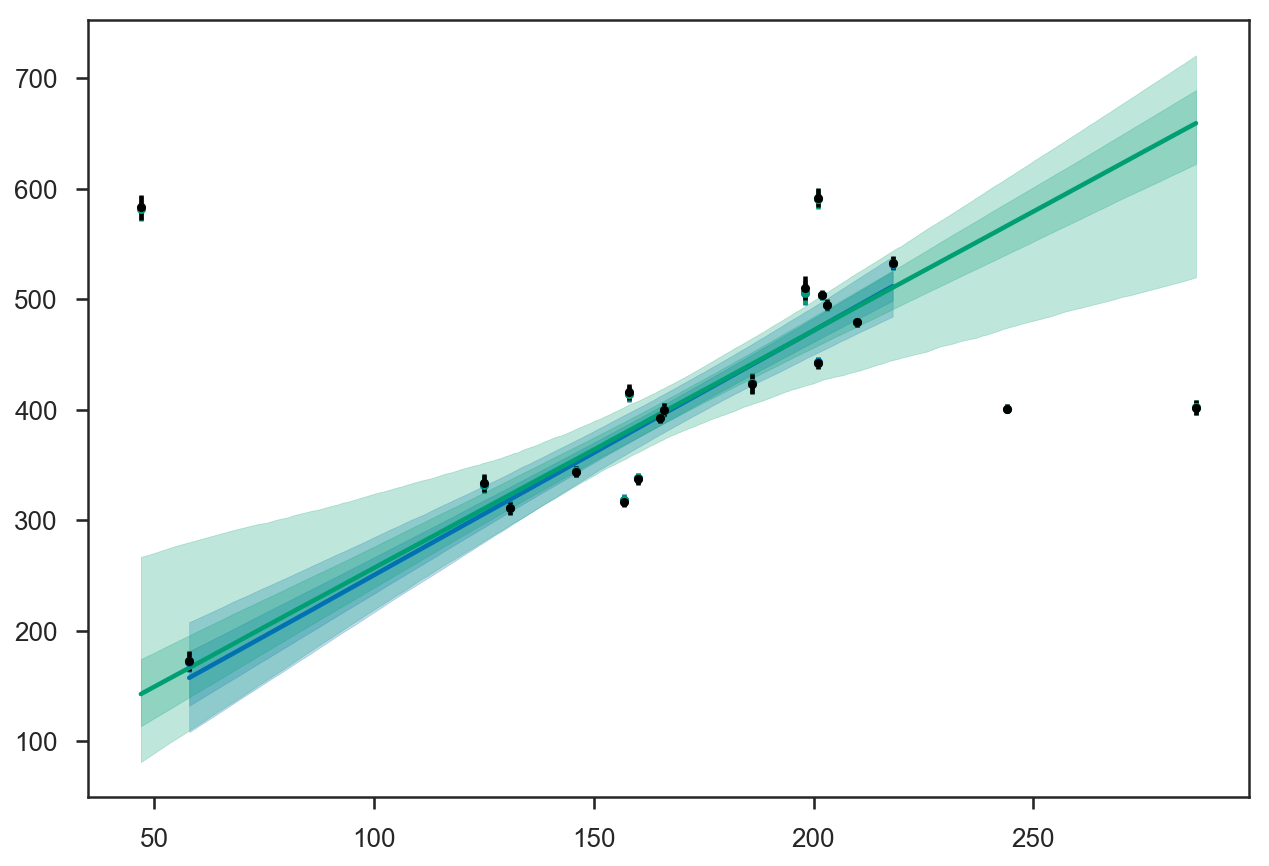

In [112]:
plot_errorbands(linspace(np.min(table1['x'][ex1N0:]), np.max(table1['x'][ex1N0:]), 1000), samples_scatter['m'], samples_scatter['b'])
plot_errorbands(linspace(np.min(table1['x']), np.max(table1['x']), 1000), samples_outliers['m'], samples_outliers['b'])
errorbar(table1['x'][ex1N0:], mean(samples_scatter['y_true'], axis=0), yerr=std(samples_scatter['y_true'], axis=0), fmt='.', color=sns.color_palette()[0])
errorbar(table1['x'], mean(samples_outliers['y_true'], axis=0), yerr=std(samples_outliers['y_true'], axis=0), fmt='.', color=sns.color_palette()[1])
errorbar(table1['x'], table1['y'], yerr=table1['sigma_y'], fmt='.', color='k')

I think we are going to stop here, but useful homework could be: introduce a $x_\mathrm{true}$ parameter, and incorporate the $x$ observational uncertainties in one or more of these models and check the fits, etc.